In [1]:
import polars as pl
import warnings
import pandas as pd
from tqdm import tqdm
import glob
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
sub = pd.read_csv('submission_format.csv')

In [3]:
train = pd.read_parquet("train_df.parquet") #Uploading the dataset obtained from the concat_df_train.ipynb notebook

In [4]:
train['month'] = train['date'].apply(lambda x: int(x.split('-')[1]))
train['vegetation_index'] = train['vegetation_index'].fillna(-1)

In [5]:
def split_train_val(df: pd.DataFrame):
    """
    To test the hypothesis, we cut off for validation similar months of last year 2022-09-01, 2022-12-01, 2023-03-01

    """
    
    df_9 =pd.concat([df[df['month'] == 9],df[df['month'] == 8]])
    df9_val = df_9[df_9['date'] == '2021-09-01']
    df9_train = df_9[df_9['date'] < '2021-09-01']
    df9_train['month'] = df9_train['month'].replace(8,9)

    df_12 =pd.concat([df[df['month'] == 12],df[df['month'] == 11]])
    df12_val = df_12[df_12['date'] == '2021-12-01']
    df12_train = df_12[df_12['date'] < '2021-12-01']
    df12_train['month'] = df12_train['month'].replace(11,12)

    df_3 = df[df['month'] == 3]
    df3_val = df_3[df_3['date'] == '2021-03-01']
    df3_train = df_3[df_3['date'] < '2021-03-01']

    return pd.concat([df9_train,df12_train,df3_train]), pd.concat([df9_val,df12_val,df3_val])
       

In [6]:
train_data, val_data = split_train_val(train)

In [7]:
data_features = train_data.groupby(['lat','long','month']).agg({'vegetation_index': ['mean']})
data_features.columns = ['vegetation_index_mean']
data_features = data_features.reset_index()

In [8]:
pred_mean_df = val_data.merge(data_features,how='left',on=['month','lat','long'])

In [9]:
rmse = math.exp(-(mean_squared_error(pred_mean_df['vegetation_index'],pred_mean_df['vegetation_index_mean'], squared = False)))
print(f'The metric is on validation: {rmse}')

The metric is on validation: 0.9357039982508997


<AxesSubplot:>

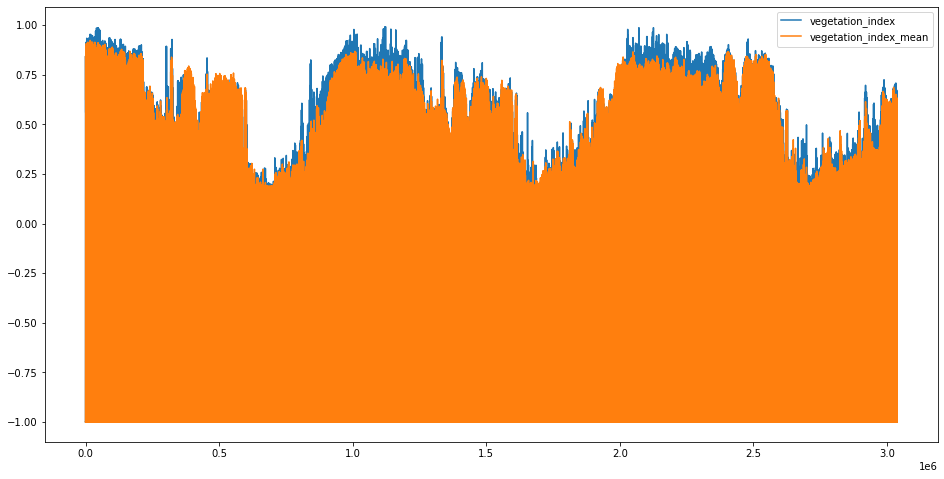

In [10]:
pred_mean_df[['vegetation_index', 'vegetation_index_mean']].plot(label='RELIANCE',figsize=(16, 8))

In [11]:
#Making a prediction for the specified dates 2023-09-01,2023-12-01,2024-03-01

In [12]:
df_9 =pd.concat([train[train['month'] == 9],train[train['month'] == 8]])
df_9['month'] = df_9['month'].replace(8,9)

df_12 =pd.concat([train[train['month'] == 12],train[train['month'] == 11]])
df_12['month'] = df_12['month'].replace(11,12)

df_3 = train[train['month'] == 3]

In [13]:
train_data = pd.concat([df_9,df_12,df_3])
train_data['vegetation_index'] = train_data['vegetation_index'].fillna(-1)

In [14]:
data_features = train_data.groupby(['lat','long','month']).agg({'vegetation_index': lambda x: x.mean()})
data_features = data_features.reset_index()

In [15]:
def split_text(x):
    if x.split('-')[0] == '230901':
        y = 9
    elif x.split('-')[0] == '231201':
        y = 12
    else:
        y = 3
    return y

In [16]:
sub['month'] = sub['id'].apply(lambda x: split_text(x))
sub['lat'] = sub['id'].apply(lambda x: float(x.split('(')[1].split(':')[0]))
sub['long'] = sub['id'].apply(lambda x: float(x.split('(')[1].split(':')[1].split(')')[0]))

In [17]:
sub_df = sub.drop('vegetation_index',axis=1).merge(data_features,how='left',on=['month','lat','long'])

In [18]:
sub_df['vegetation_index'] = sub_df['vegetation_index'].round(4)

In [19]:
sub_df[['id','vegetation_index']].to_csv('sub_progres.csv',index=False)